## Selected Dataset: Elliptic Data Set

**Selection Date**: 2025-08-29  
**Selected from**: dataset-exploration-risk-scoring-research.md  
**Rank**: #1 out of 10 evaluated datasets  
**Suitability Score**: 92/100  

### Dataset Overview

### **Elliptic Data Set**
- **Source Platform**: Kaggle
- **Direct URL**: https://www.kaggle.com/datasets/ellipticco/elliptic-data-set
- **Data Set Provider**: https://www.elliptic.co/
- **Dataset Size**: 200,000 transactions � 166 features, ~697.46MB
- **Problem Relevance**: High - Bitcoin illicit transaction classification
- **Data Quality**: Excellent - professionally curated by Elliptic Co.
- **License Type**: Open (with attribution requirements)
- **Last Updated**: 2019 (stable reference dataset)
- **Preprocessing Needs**: Minimal - ready for ML training
- **Special References**: [2] M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.


### Key Features and Structure

### Feature Categories
- **Local Features**: 94 transaction-specific features
- **Aggregate Features**: 72 neighborhood/graph-based features  
- **Total Features**: 166 feature dimensions
- **Temporal Component**: Time step information included
- **Labels**: Binary classification (illicit = 1/licit = 2)

### Specific Features Include:
- Transaction fees
- Input/output volumes  
- Neighbor aggregates
- Time steps
- BTC amounts
- Graph topology metrics
- Wallet clustering information

### Importing libraries

Import required libraries and packages

In [22]:
!pip install azure-storage-blob

from pathlib import Path
from azure.storage.blob import BlobServiceClient


"""
Utility functions for dataset processing and Azure blob storage operations.
"""
class AzureBlobDownloader:
    """
    Azure Blob Storage downloader class for managing dataset downloads.

    This class encapsulates Azure blob operations and maintains connection state
    for efficient dataset management operations.
    """

    def __init__(self, account_url, container_name):
        """
        Initialize Azure blob downloader.

        Args:
            account_url (str): Azure storage account URL
            container_name (str): Name of the blob container

        Raises:
            Exception: If connection to Azure fails or Azure SDK not available
        """
        try:
            self.account_url = account_url
            self.container_name = container_name
            self.blob_service_client = BlobServiceClient(account_url=account_url)
            self.container_client = self.blob_service_client.get_container_client(container_name)

        except Exception as e:
            raise Exception(f"Failed to initialize Azure Blob connection: {e}")


    def download_documents(self, project_folder, document_folder, base_path="../"):
        """
        Download dataset from Azure Blob Storage.

        Args:
            dataset_name: Name of the dataset directory in blob storage
            base_path: Local base path for downloads (default: "../")

        Returns:
            bool: True if download successful, False otherwise
        """
        try:
            original_dir = Path(base_path) / project_folder 
            specific_dir = original_dir / document_folder

            original_dir.mkdir(exist_ok=True)
            specific_dir.mkdir(exist_ok=True)

            remote_path = f"{project_folder}/{document_folder}/"
            downloaded_files = 0

            for blob in self.container_client.list_blobs(name_starts_with=remote_path):
                blob_client = self.container_client.get_blob_client(blob.name)
                local_file_path = Path(base_path) / blob.name
                local_file_path.parent.mkdir(parents=True, exist_ok=True)

                blob_data = blob_client.download_blob()
                with open(local_file_path, "wb") as download_file:
                    download_file.write(blob_data.readall())
                downloaded_files += 1

            print(f"Successfully downloaded {downloaded_files} files from Azure Blob Storage")
            return True

        except Exception as e:
            print(f"Failed to download from Azure Blob Storage: {e}")
            return False

In [23]:
import warnings
import numpy as np
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from IPython.display import display
from pathlib import Path
warnings.filterwarnings('ignore')

try:
    import kaggle
except OSError:
    print("Kaggle configuration not found, no worries we have azure.")

# Set renderer for VS Code compatibility
pio.renderers.default = "colab"

azureClient = AzureBlobDownloader("https://stmvppos.blob.core.windows.net", "mvpkytsup")

### Dataset Visualization Strategy

Let's visualize the dataset in order to check which pre-process to apply:
 1. Create the dataset directory and download the original data from source
 2. Load all datasets
 3. Display the feature dataset
 4. Display the classes and edges

**1. Create the dataset directory and download the original data from source**

In [24]:
# Download dataset from Azure Blob Storage or Kaggle if not already present
dataset_str  = "elliptic_bitcoin_dataset"
dataset_dir = Path(dataset_str)
original_str  = "original"
original_dir = Path("../original")
specific_dir = original_dir / dataset_dir

if(specific_dir.exists() and any(specific_dir.iterdir())):
    print(f"Dataset already exists in {original_dir}, skipping download.")
elif azureClient.download_documents(original_str, dataset_str):
    print("Download from Azure Blob Storage completed successfully.")
else:
    print("Falling back to Kaggle download...")
    original_dir.mkdir(exist_ok=True)
    dataset_name = "ellipticco/elliptic-data-set"
    kaggle.api.dataset_download_files(
        dataset_name, 
        path=str(original_dir), 
        unzip=True
    )

Dataset already exists in ../original, skipping download.


**2. Load all datasets**


In [25]:
features_file = specific_dir / "elliptic_txs_features.csv"
if features_file.exists(): df_features = pd.read_csv(features_file, header=None)
else: df_features = pd.DataFrame()
classes_file = specific_dir / "elliptic_txs_classes.csv"
if classes_file.exists(): df_classes = pd.read_csv(classes_file)
else: df_classes = pd.DataFrame()
edges_file = specific_dir / "elliptic_txs_edgelist.csv"
if edges_file.exists(): df_edges = pd.read_csv(edges_file)
else: df_edges = pd.DataFrame()

**3. Display the feature dataset**

In [26]:
# Summary of all datasets
print(f"\n📊 Dataset Summary:")
print(f"  - Features: {df_features.shape[0]:,} transactions × {df_features.shape[1]} features")
print(f"  - Classes: {df_classes.shape[0]:,} labeled transactions")
print(f"  - Edges: {df_edges.shape[0]:,} transaction relationships")

# Try Plotly table with explicit display
try:
    print("\n📋 Interactive Plotly Table (first 100 rows, first 10 columns):")
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df_features.columns[:10]),
            fill_color='paleturquoise',
            align='left'
        ),
        cells=dict(
            values=[df_features.iloc[:10000, i] for i in range(10)],
            fill_color='lavender',
            align='left'
        )
    )])
    fig.update_layout(title="Features Dataset - Interactive Table")
    
    # Multiple display attempts for VS Code compatibility
    fig.show(renderer="colab")
    
except Exception as e:
    print(f"⚠️ Plotly display failed: {e}")
    print("Using pandas display instead:")
    display(df_features.head(10))


📊 Dataset Summary:
  - Features: 203,769 transactions × 167 features
  - Classes: 203,769 labeled transactions
  - Edges: 234,355 transaction relationships

📋 Interactive Plotly Table (first 100 rows, first 10 columns):


**4. Display the classes and edges**

In [27]:
# Display sample data using pandas
print("\n🔍 Classes Dataset Sample:")
display(df_classes.head(10))

print("\n🔍 Edges Dataset Sample:")
display(df_edges.head(10))


🔍 Classes Dataset Sample:


,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
5,230459870,unknown
6,230333930,unknown
7,230595899,unknown
8,232013274,unknown
9,232029206,2



🔍 Edges Dataset Sample:


,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
5,232344069,27553029
6,36411953,230405052
7,34194980,5529846
8,3881097,232457116
9,230409257,32877982


### Dataset Analysis Strategy

Let's analyze the following: 
1. Check if the data is already in standard scale format
2. Check for dataset class balance 

**1. Check if the data is already in standard scale format**

In [28]:
# Check if df_features is in standard scale format (mean ≈ 0, std ≈ 1)
numerical_features = df_features.iloc[:, 1:]  # Exclude txId column
means = numerical_features.mean()
stds = numerical_features.std()

# Standardization check
is_standardized = (abs(means) < 0.1).all() and ((stds > 0.9) & (stds < 1.1)).all()

print(f"📊 Feature Standardization Check:")
print(f"  Mean range: [{means.min():.3f}, {means.max():.3f}]")
print(f"  Std range: [{stds.min():.3f}, {stds.max():.3f}]")
print(f"  Is standardized: {'✅ Yes' if is_standardized else '❌ No'}")

📊 Feature Standardization Check:
  Mean range: [-0.000, 23.844]
  Std range: [1.000, 15.172]
  Is standardized: ❌ No


**2. Check for dataset class balance**

⚖️ Class Balance: 203,769 total samples
  unknown: 157,205 (77.1%)
  2: 42,019 (20.6%)
  1: 4,545 (2.2%)
  Imbalance ratio: 9.2:1
  Status: ❌ Highly imbalanced


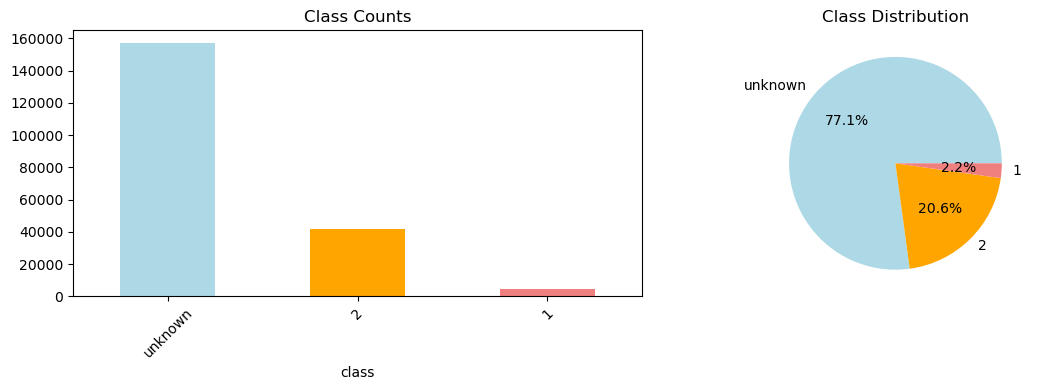

In [29]:
# Class balance analysis
class_counts = df_classes['class'].value_counts()
labeled_only = class_counts[class_counts.index != 'unknown']
imbalance_ratio = labeled_only.max() / labeled_only.min() if len(labeled_only) >= 2 else 1.0

print(f"⚖️ Class Balance: {len(df_classes):,} total samples")
for cls, count in class_counts.items():
    print(f"  {cls}: {count:,} ({count/len(df_classes)*100:.1f}%)")
print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"  Status: {'✅ Balanced' if imbalance_ratio <= 1.5 else '⚠️ Imbalanced' if imbalance_ratio <= 3.0 else '❌ Highly imbalanced'}")

# Plot distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
class_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'orange', 'lightcoral'])
ax1.set_title('Class Counts')
ax1.tick_params(axis='x', rotation=45)
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightblue', 'orange', 'lightcoral'])
ax2.set_title('Class Distribution')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()

📊 PCA Summary:
Number of components: 59


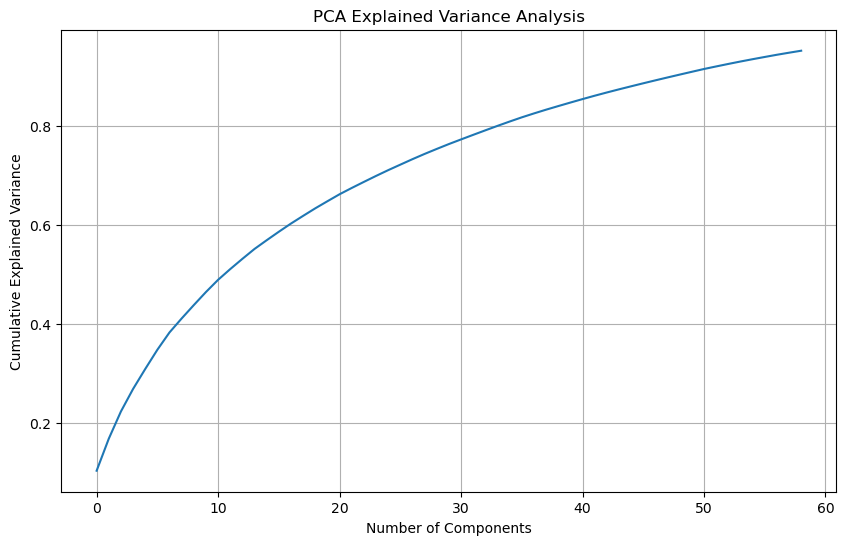

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46
0,-23.259326,-1.334205,-0.389841,0.858641,0.119258,1.548138,3.620466,-1.062795,0.324274,-0.951837,...,-0.003542,-0.280773,-0.261116,0.365241,0.063090,0.808743,-0.487075,0.542121,0.711388,-0.104503
1,-23.214950,-1.225925,-0.864646,-1.626955,-0.244241,-0.486241,-3.293548,1.299013,-0.895587,-1.010517,...,-0.609010,0.137082,-0.368852,0.098917,-0.311573,-1.004552,0.472676,0.002914,0.201565,-0.452291
2,-23.367950,-1.736658,-0.523871,-0.352799,0.338871,-4.867673,-2.275286,-0.432034,-0.574862,-0.302048,...,-1.701086,1.127281,0.596223,0.178142,0.229534,0.536207,-0.733945,0.137289,-0.144425,-0.086396
3,-23.252862,1.751371,0.928048,4.294071,-0.492906,-1.577796,1.643396,4.899541,3.281473,9.868766,...,-0.945445,-0.771680,-2.135080,-0.892968,0.283579,-1.484045,2.710147,0.599461,-0.179944,5.052601
4,-23.285418,-1.932813,1.046309,-1.015367,1.260080,-0.516014,0.371045,0.883672,1.618990,2.685468,...,0.393280,0.376079,0.703365,-0.198470,-1.024707,0.530068,0.380833,0.022541,-0.314625,0.688582
5,-23.250754,-1.709209,0.839210,-0.598289,1.233545,-0.666905,0.593146,0.919528,0.785327,2.018745,...,-0.296161,0.610694,0.094704,-0.134281,0.397856,0.044554,0.470172,0.048956,0.047746,0.126555
6,-23.150367,1.511929,-1.116933,-0.285150,-0.093218,3.356342,0.224089,0.706185,0.618384,0.692899,...,-0.794695,0.859375,0.228662,0.430657,0.382079,1.238856,-0.361235,0.217416,-0.064513,0.529157
7,-23.374253,-2.530356,-0.742398,-2.342152,3.470030,-5.276851,-0.680460,1.953859,1.244515,3.499585,...,-1.661351,1.623817,0.754622,-0.199895,1.538749,-1.010147,-0.745179,0.310654,-0.102941,-0.454120
8,-23.323939,-2.022254,-0.402877,-0.405482,0.171173,-3.861495,-1.556969,-0.907260,-0.243755,-0.482659,...,1.387680,-0.450007,0.188334,0.098543,-0.031625,0.600590,-0.261676,-0.056771,0.145069,-0.231663
9,-23.225479,1.435087,0.100476,2.717498,0.348142,-1.322060,1.296957,2.869675,2.574131,6.896562,...,-0.757072,-1.250756,-0.940624,0.196344,0.295706,-0.177004,1.629134,-0.472845,-0.255056,0.427002


In [30]:
# Apply standard scaling if not already standardized
if not is_standardized:
    scaler = StandardScaler()
    df_features_standard = scaler.fit_transform(df_features.drop(columns=[0]))  # Exclude txId column

# Choose number of components (e.g., 95% variance retention)
pca = PCA(n_components=0.95)  # Retain 95% of variance
pca_features = pca.fit(df_features_standard)  # Exclude txId column for PCA

# Summary of PCA
print(f"📊 PCA Summary:")
print(f"Number of components: {pca.n_components_}")

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_features.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Analysis')
plt.grid(True)
plt.show()

# Create new DataFrame with PCA features
pca_features = pca.fit_transform(df_features.drop(columns=[0]))  # Exclude txId column for PCA
pca_columns = [f'PC{i+1}' for i in range(pca_features.shape[1])]
df_features_pca = pd.DataFrame(pca_features, columns=pca_columns,
index=df_features.index)
display(df_features_pca.head(10))

### Dataset Preparations Strategy

Let's prepare the data to training steps:
1. Filter transactions to include only labeled data (classes 1 and 2)
2. Compress and save the processed dataset for next steps
3. Update external data warehouse

**1. Filter transactions to include only labeled data (classes 1 and 2)**

In [31]:
# Display complete dataset
print("Complete dataset")
df_complete = df_features.merge(df_classes, left_on=df_features.columns[0], right_on=df_classes.columns[0], how='inner')
df_complete = df_complete.drop('txId', axis=1)
df_complete = df_complete.rename(columns={df_complete.columns[0]: 'txId'})
df_complete['class'] = df_complete['class'].map({'1': 0, '2': 1}) # Binary target
display(df_complete.head(10))

# Display labeled dataset
print("Labeled dataset")
labeledRowSelector = df_complete['class'].isin([0, 1])
df_labeled = df_complete[labeledRowSelector].copy().reset_index(drop=True)
display(df_labeled.head(10))

# Display unlabeled dataset
print("Unlabeled dataset")
unlabeledRowSelector = df_complete['class'].isna()
df_unlabeled = df_complete[unlabeledRowSelector].copy().reset_index(drop=True)
display(df_unlabeled.head(10))

# Display edges dataset with renamed columns
print("Edges dataset")
df_edges = df_edges.rename(columns={df_edges.columns[0]: 'source', df_edges.columns[1]: 'destination'})
display(df_edges.head(10))

Complete dataset


,txId,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,NaN
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,1.0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,NaN
5,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,NaN
6,230333930,1,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161887,...,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
7,230595899,1,-0.171755,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163552,...,0.704641,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
8,232013274,1,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.112635,...,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,NaN
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,1.0


Labeled dataset


,txId,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,1.0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,1.0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,1.0
5,232457116,1,-0.172304,-0.184668,-1.201369,-0.046932,-0.024025,-0.029140,-0.061584,-0.163637,...,-0.596794,1.297854,1.297925,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
6,232412405,1,-0.165140,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.155621,...,-0.607306,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,1.0
7,232470342,1,-0.172350,-0.155133,0.463609,0.328255,-0.043875,0.390171,-0.061584,-0.163645,...,-0.582077,1.461330,1.461369,0.252616,0.066306,0.147731,0.333211,-1.760926,-1.760984,1.0
8,230550393,1,0.028482,0.048298,-1.201369,1.678931,-0.063725,1.564243,-0.061584,-0.163639,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
9,232051089,1,-0.172914,-0.184668,-1.201369,-0.046932,-0.024025,-0.029140,-0.061584,-0.163639,...,-0.584179,1.039938,0.851388,0.018279,-0.068266,-0.093204,-0.068808,-0.120613,-0.119792,1.0


Unlabeled dataset


,txId,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,NaN
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,NaN
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,NaN
5,230333930,1,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161887,...,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
6,230595899,1,-0.171755,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163552,...,0.704641,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
7,232013274,1,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.112635,...,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,NaN
8,36411953,1,-0.172621,-0.162277,0.463609,-0.046932,-0.043875,-0.029140,-0.061584,-0.163512,...,-0.531617,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,NaN
9,230405052,1,-0.172822,-0.162277,0.463609,-0.046932,-0.043875,-0.029140,-0.061584,-0.163573,...,-0.594691,1.461330,1.461369,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,NaN


Edges dataset


,source,destination
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
5,232344069,27553029
6,36411953,230405052
7,34194980,5529846
8,3881097,232457116
9,230409257,32877982


**2. Compress and save the processed dataset for next steps**

In [32]:
processed_dir = Path("../processed")
complete_dir =  processed_dir / dataset_dir
processed_dir.mkdir(exist_ok=True)
complete_dir.mkdir(exist_ok=True)

# Save df_complete to HDF5 with Blosc compression
df_complete.to_hdf(complete_dir / "df_complete.h5", key="df_complete", 
                   complevel=5, complib="blosc", format="table")
print(f"df_complete saved: {df_complete.shape}")

# Save df_labeled to HDF5 with Blosc compression
df_labeled.to_hdf(complete_dir / "df_labeled.h5", key="df_labeled", 
                   complevel=5, complib="blosc", format="table")
print(f"df_labeled saved: {df_labeled.shape}")

# Save df_unlabeled to HDF5 with Blosc compression
df_unlabeled.to_hdf(complete_dir / "df_unlabeled.h5", key="df_unlabeled", 
                   complevel=5, complib="blosc", format="table")
print(f"df_unlabeled saved: {df_unlabeled.shape}")

# Save df_edges to HDF5 with Blosc compression
df_edges.to_hdf(complete_dir / "df_edges.h5", key="df_edges", 
                   complevel=5, complib="blosc", format="table")
print(f"df_edges saved: {df_edges.shape}")

#TODO: Save all data frames in azure blob storage

df_complete saved: (203769, 168)
df_labeled saved: (46564, 168)
df_unlabeled saved: (157205, 168)
df_edges saved: (234355, 2)
